# LSTM을 이용한 주가 예측

In [ ]:
! pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [ ]:
aapl = yf.download('AAPL', start = '2015-01-01', end='2022-4-21', progress=False) # aapl : 애플의 주식 코드
aapl.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02 00:00:00+00:00,24.347178,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05 00:00:00+00:00,23.661272,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06 00:00:00+00:00,23.663504,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07 00:00:00+00:00,23.995312,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08 00:00:00+00:00,24.917267,27.972500,28.037500,27.174999,27.307501,237458000


In [ ]:
aapl.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2022-04-13 00:00:00+00:00,167.867325,170.399994,171.039993,166.770004,167.389999,70618900
2022-04-14 00:00:00+00:00,162.833252,165.289993,171.270004,165.039993,170.619995,75329400
2022-04-18 00:00:00+00:00,162.616562,165.070007,166.600006,163.570007,163.919998,69023900
2022-04-19 00:00:00+00:00,164.911926,167.399994,167.820007,163.910004,165.020004,67723800
2022-04-20 00:00:00+00:00,164.744431,167.229996,168.880005,166.100006,168.759995,67929800


Text(0.5, 1.0, 'APPLE stock price')

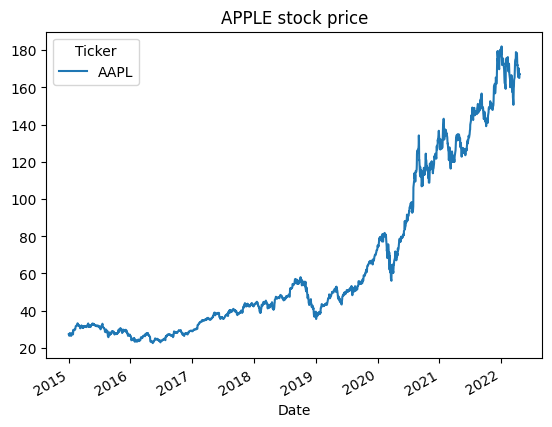

In [ ]:
# 주식 가격 시각화
aapl.Close.plot()
plt.title('APPLE stock price')

In [ ]:
aapl.shape # 시초가, 고가, 적가, 종가, Adj Close(액면분할, 배당을 감안)

(1838, 6)

- Apple 주식 가격 예측

LSTM layer로 하려고 하는 것은 지난 window-size 일(즉, t-window에서 t-1까지)의 역사적 가격을 사용하여 시간 t의 가격을 예측하는 것입니다. 정확한 가격이 아닌 추세를 파악하기 위해 노력할 것임을 명심하십시오.
- 올라가는지, 내려가는지 패턴을 인식하는데 특화되어 있음 정확하게 얼마인지 알아맞추는 건 아니다!!

- training dataset 생성

In [ ]:
hist = []
target = []

window = 3 # 과거 3일의 데이터를 가지고 오늘의 주가를 알아맞춰보자
close = aapl['Close'].values # 알아맞출 데이터
# len(close) : 1838

for i in range(len(close) - window): # 윈도우 개수만큼 남겨놔야한다
  x = close[i : i+window] #  i번째부터 i+window까지 --> 0,1,2, 과거 3개의 데이터
  y = close[i + window]
  # 3개의 데이터를 가지고 다음 거 하나를 알아 맞추는 구성 --> 심플 LSTM 했을 때 하고 똑같은 요령
  hist.append(x)
  target.append(y)

In [ ]:
close[:10]

array([[27.33250046],
       [26.5625    ],
       [26.56500053],
       [26.9375    ],
       [27.97249985],
       [28.00250053],
       [27.3125    ],
       [27.55500031],
       [27.45000076],
       [26.70499992]])

In [ ]:
hist[:5] # close에 있는 10개의 주식 가격 데이터를 3개씩 묵어서 10개의 array 반환
# 날짜(window)를 하나씩 움직인다 --> 연속된 3일치의 데이터
# 두번째 요소의 마지막 항목 = target의 첫 번째 요소랑 같으면 잘 만들어진거임!!

[array([[27.33250046],
        [26.5625    ],
        [26.56500053]]),
 array([[26.5625    ],
        [26.56500053],
        [26.9375    ]]),
 array([[26.56500053],
        [26.9375    ],
        [27.97249985]]),
 array([[26.9375    ],
        [27.97249985],
        [28.00250053]]),
 array([[27.97249985],
        [28.00250053],
        [27.3125    ]])]

In [ ]:
target[:5] # 첫 번째 array : 과거 3일치의 데이터를 가지고 4번째 26.9375를 알아 맞추는 것
 # 시퀀스 데이터를 지도학습용으로 변형시켜주는 요령
 # 날짜 순서를 가진 이런 데이터들의 지도학습 데이터는 자기 자신으로부터 나옴
 # 입력 데이터도 자기 자신 & target도 자기 자신의 그 데이터의 일부

[array([26.9375]),
 array([27.97249985]),
 array([28.00250053]),
 array([27.3125]),
 array([27.55500031])]

확인 방법

- "hist"의 각 요소는 window개 timestep의 list입니다. 1씩 증가하기 때문에 "hist"의 두 번째 요소의 마지막 항목은 "target"의 첫 번째 요소와 같아야 합니다. 또한 마지막 숫자가 같아야 합니다.

```
print(close[-1])
print(i+length)
print(target[-1])
```

In [ ]:
hist[1][-1] == target[0] # 이게 true가 나오면 데이터가 잘 만들어진거임!! 확인방법

array([ True])

In [ ]:
hist = np.array(hist)
target = np.array(target).reshape(-1, 1) # target이 vector 형태로 돼 있어서 reshape 해준다!
# .reshape(-1,1) : 개수만큼해서 matrix 형태로 reshape이 되었음
hist.shape, target.shape # 3일치의 데이터를 받아서 그 다음날 종가를 알아 맞추는 모양

((1835, 3, 1), (1835, 1))

1098일의 데이터로 모델을 학습시키고 다음 100일의 데이터로 테스트하는 방식으로 데이터를 분할합니다.
- 시계열 데이터는 섞으면 안됨!
- 어디서부터 어디까진 훈련용, 나머지는 검증용으로 나눠야함

In [ ]:
split = len(hist) - 100
split # 1735개는 학습용 데이터로 사용

1735

In [ ]:
# train_test_split : 이건 일반 데이터용, 랜덤으로 셔플했음
split = len(hist) - 100 # 1700일치 정도 데이터로 모델 학습 시키고, 다음 100일 데이터로 테스트하는 방식
X_train = hist[:split]
X_test = hist[split:]
y_train = target[:split]
y_test = target[split:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1735, 3, 1), (100, 3, 1), (1735, 1), (100, 1))

In [ ]:
X_train = X_train.reshape(-1, window, 1)
X_tes = X_test.reshape(-1, window, 1)

X_train.shape, X_test.shape
# LSTM이라는 함수의 입력 format은 batch_size , 타임 시퀀스, 피처 개수 --> 3 dimension 데이터

((1735, 3, 1), (100, 3, 1))

**Min-Max 스케일링**

In [ ]:
#sc1 = MinMaxScaler() # 주식 가격 변화, 즉 정답값 자체가 크게 변해주기 때문에 스케일링을 해줘야 잘 맞출 수 있음

# 훈련 데이터 스케일링
# X_train_scaled = sc1.fit_transform(X_train) 3차원 데이터여서 스케일링이 안되는 상태
#X_test_scaled = sc1.transform(X_test)

# 테스트 데이터 스케일링
#sc2 = MinMaxScaler()
#y_train_scaled = sc2.fit_transform(y_train)
#y_test_scaled = sc2.transform(y_test)

#X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape
# ((1735,3),(100,3),(1735,1),(100,1))이 나와야함 --> 근데 차원이 하나 더 늘어야함


# model 생성 및 fitting
3개의 LSTM 층을 쌓았음 --> 마지막엔 Dense 레이어와 연결

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences = True, input_shape = (window, 1), dropout = 0.2)) # 첫 번째 LSTM하고 두 번째 LSTM이 연결되려면 return_sequences=True
model.add(LSTM(32, return_sequences = True, dropout = 0.2))
model.add(LSTM(16, dropout = 0.2)) # 다음에 LSTM이 연속으로 안오기 때문에 dropout만 해준다
model.add(Dense(1)) # 숫자 하나 예측하는 거니깐 Dense(1)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 3, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 3, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,465 (126.82 KB)

 Trainable params: 32,465 (126.82 KB)

 Non-trainable params: 0 (0.00 B)

# 모델 컴파일

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16)

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4845.1484
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4140.3555
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3829.2466
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3720.6809
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3487.0513
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3474.0991
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3153.4026
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3116.5520
Epoch 9/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3050.5415
Epoch 10/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2756.3445
Epoch 11/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2878.9712
Epoch 12/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2813.9197
Epoch 13/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2628.0718
Epoch 14/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2307.5708
Epoc

Text(0, 0.5, 'mse')

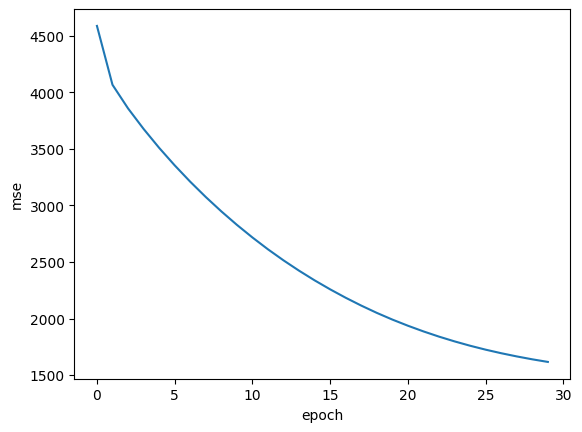

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('mse')

앞으로 100일 동안의 주가 추이를 예측해 보도록 하겠습니다. 우리의 목표는 실제 가격이 아니라 추세를 예측하는 것임을 기억하십시오.

In [ ]:
y_train.shape

(1735, 1)

In [ ]:
y_train.flatten().shape # vector 형태로 되어야 한 그림 안에 연속된 숫자로 그릴 수가 있다.

(1735,)

# 예측 주가 시각화

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


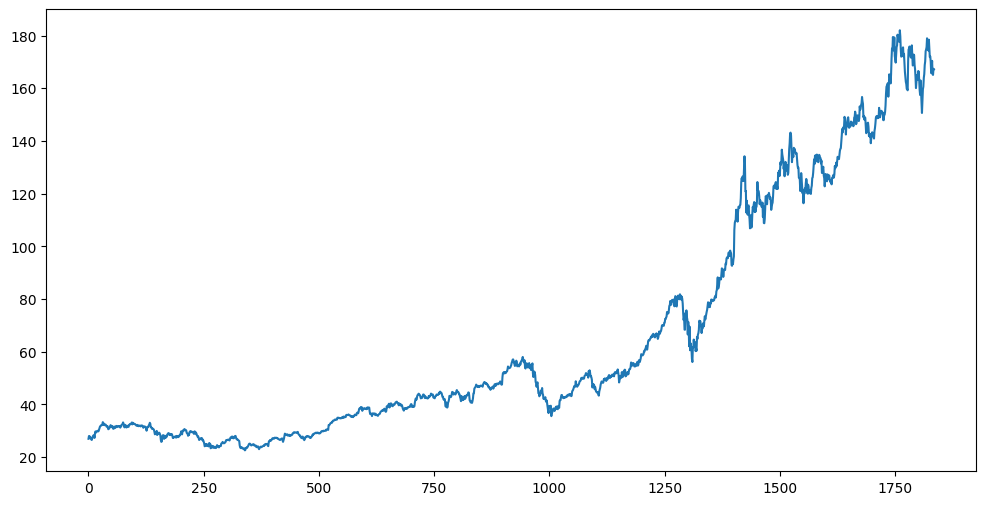

In [ ]:
pred = model.predict(X_test)

plt.figure(figsize = (12,6))
plt.plot(np.concatenate((y_train.flatten(), y_test.flatten())), label = "original data")
plt.plot(np.concatenate((y_train.flatten(), pred.flatten())), label = "prediction")

plt.title('Apple Stock Price Prediction')
plt.legend()

## 다양한 window_size tuning 을 하여 보다 정확한 예측 시도